# Loan prediction

<div class="alert alert-block alert-info"><b>Note1:</b> I appologize for grammar mistakes and typos in advance, not a natural english speaker. I am writing my notes in english becasue I want to improve my writing skills and to make it available to a wider audience.</div>

<div class="alert alert-block alert-info"><b>Note 2:</b> I am posting it online to GitHub for everyone else to see, so feel free to write me if you want, every feedback is precious!</div>

## Introduction 

___

Data set contains information about customers, who are applying for a loan and contains 615 rows & 13 columns.

**Goal:**

1. Predict whether customer should get a loan or not.

**Agenda:**

- [x] get the data and explore them to get an insight
- [x] clean and prepare your data
- [x] explore many different ml methods and chose the best one (or group of them) 
- [x] fine-tune your model/s 
- [ ] ~~present your solution~~
- [ ] ~~launch, monitor, and maintain your system~~

Final sequence of tasks could be slightly different. Let's dive into ML!

<p style="background:white">
<code style="background:white;color:white">
</code>
</p>

## Data Exploration and visualization

___

Basic imports, others will be imported as needed.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

### Loading data and first look

Test is provided withou labels, so I will use train for test and train.

In [124]:
loan_train_exploration = pd.read_csv("train.csv")
loan_train_exploration.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
loan_train_exploration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


<div class="alert alert-block alert-success"><b>First observations:</b></div>

- Loan_ID is useless -> I will drop this column.
- Gender Nan values -> I will just replace values based on proportions.
- Married Nan will be replaced wheter customer has dependetns or not.
- Dependents - for nan values I would probably use median or 0.
- Self_employed, we will need to replace Nan and maybe try to differentiate ML algorithm for employed and self_employed (in most cases banks have different evaluation process.
- LoanAmount - I will drop rows where we don't have any information about LoanAmount, make no sense decide wheter to give a loan or not if we don't know the ammount of that loan.
- Loan amount term - I think it will be sufficient to fill Nan with average values.
- Credit_history is very important feature, I will have to try more Nan filling variants (some basic method, assumpiton that if criedt_history = Nan = 0 , and ML model -> if it achives good results.

I will also want to try add some new columns, or delete some unimportant ones. Let's explore some of them moore deeply.

### Columns step by step

I need to gen an better insight about my data. This first exploration part is the only one I will be doing seperately. Data preparation - pipelines, training and tunning has to be done in parallel, that way I can eliminate some bugs. I consider this part to be most important, cause here I am creating a list of recommendation of how to change my data, what is important and so on, hence it has the biggest impact on model performance.

<div class="alert alert-block alert-warning"><b>Gender column</b></div>

First question we need to answer is wheter being male or female has some major effect on final evaluation.

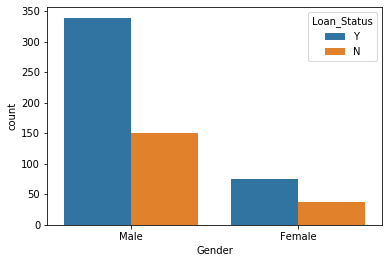

In [278]:
sns.countplot(x="Gender",data=loan_train_exploration, hue="Loan_Status")

In [93]:
gender_column = loan_train_exploration[["Gender","Loan_Status"]].groupby(["Loan_Status","Gender"]).size()
gender_column.Y[1]/(gender_column.N[1]+gender_column.Y[1]), gender_column.Y[0]/(gender_column.Y[0]+gender_column.N[0]);
#i am just counting values and dividing them - to answer simple question - what is acceptance rate for male and female?

<code style="background:yellow;color:black">Acceptace rate for male and female is 69% and 67%</code>

From countplot and our simple calculation I can assume that Gender does not have a big impact on our Loan Status(label), it would be enough just to fill Nan values based on proportion. Also it is clearly a nominal variable.

*Gender column suggestions*
- Nan based on proportion.
- Nominal variable - OneHotEncoding.

<div class="alert alert-block alert-warning"><b>Married column</b></div>

For this and other columns I will use same approach, if there won't be visible a big difference at first glance, I won't waste time on it.

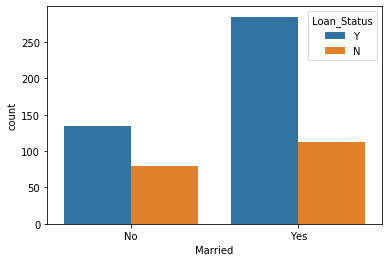

In [88]:
sns.countplot(x="Married",data=loan_train_exploration, hue="Loan_Status")

In [95]:
married_column = loan_train_exploration[["Married","Loan_Status"]].groupby(["Loan_Status","Married"]).size()
married_column.Y[1]/(married_column.N[1]+married_column.Y[1]), married_column.Y[0]/(married_column.Y[0]+married_column.N[0]);

<code style="background:yellow;color:black">Acceptace rate for married and not married is 72% and 63%</code>

Here is a slight difference so it would be better to predict wheter customer is married or not. Column has 3 Nan values so it's not so important but still, better do it right.

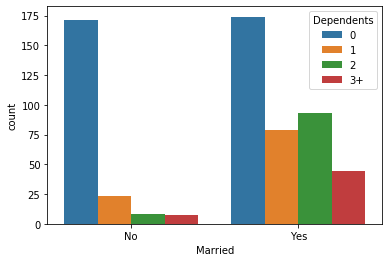

In [97]:
sns.countplot(x="Married",data=loan_train_exploration, hue="Dependents")

In [317]:
import warnings #very useful :)
warnings.filterwarnings('ignore')

loan_train_exploration["Has2Income"] = "Dont know yet"
loan_train_exploration["Has2Income"][(loan_train_exploration["CoapplicantIncome"]>0)] = "Y"
loan_train_exploration["Has2Income"][(loan_train_exploration["CoapplicantIncome"] == 0)]= "N";

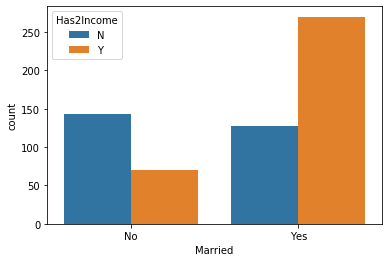

In [138]:
sns.countplot(x="Married",data=loan_train_exploration, hue="Has2Income")

From plots it's obvious that there is no clear link to Married status and CoapplicantIncome. But there is a link between Dependetns and Married status. Condition will be simple, if customer does not have any dependents his/her status will be evaluated once as married and once as not and if customer has dependetns I will evaluate as married. It is maybe a slight overkill, but data could contain much more Nan in Married column.

*Married column suggestions*
- Nan will be filled based on dependets (D =  0 => 50/50, D > 0 => Married).
- Nominal variable - OneHotEncoding.

<div class="alert alert-block alert-warning"><b>Education column</b></div>

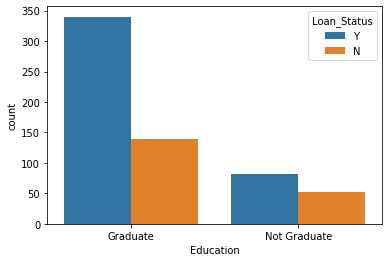

In [143]:
sns.countplot(x="Education",data=loan_train_exploration, hue="Loan_Status")

In [148]:
education_column = loan_train_exploration[["Education","Loan_Status"]].groupby(["Loan_Status","Education"]).size()
education_column.Y[1]/(education_column.N[1]+education_column.Y[1]), \
education_column.Y[0]/(education_column.Y[0]+education_column.N[0]);

<code style="background:yellow;color:black">Acceptace rate for Graduate and Not Graduate is 70% and 61%</code>

Column does not have any Nan values so I don't need to take care about that. This column differs from others in another way,
I can definitely say that Graduate is better than Not Graduate (at least for companies providing loans) and therefore variables can be Ordinal.

*Education column suggestions*
- Zero Nan won't be providing any filling mechanism.
- Ordinal encoding (actually I will try both).

<div class="alert alert-block alert-warning"><b>Self_Employed column</b></div>

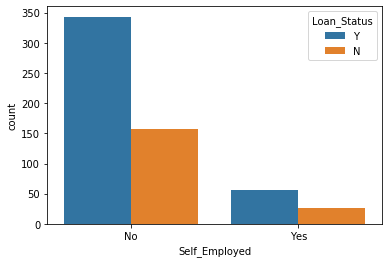

In [275]:
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Loan_Status")

In [277]:
selfe_column = loan_train_exploration[["Self_Employed","Loan_Status"]].groupby(["Loan_Status","Self_Employed"]).size()
selfe_column.Y[1]/(selfe_column.N[1]+selfe_column.Y[1]),selfe_column.Y[0]/(selfe_column.Y[0]+selfe_column.N[0]);

<code style="background:yellow;color:black">Acceptace rate for  Self _Employed and not S_Y is 68% and 68%</code>

In [151]:
loan_train_exploration[["Self_Employed","ApplicantIncome"]].groupby("Self_Employed").mean()

,ApplicantIncome
Self_Employed,
No,5049.748000
Yes,7380.817073


It's very problematic column. They have similar acceptance rate even though Self_Employed has much higher income. So companies must penalize Self_employed -> probably consider them as more risky appliers. So I cannot use same metrics for them. Firstly lets do some more plotting for better insight.

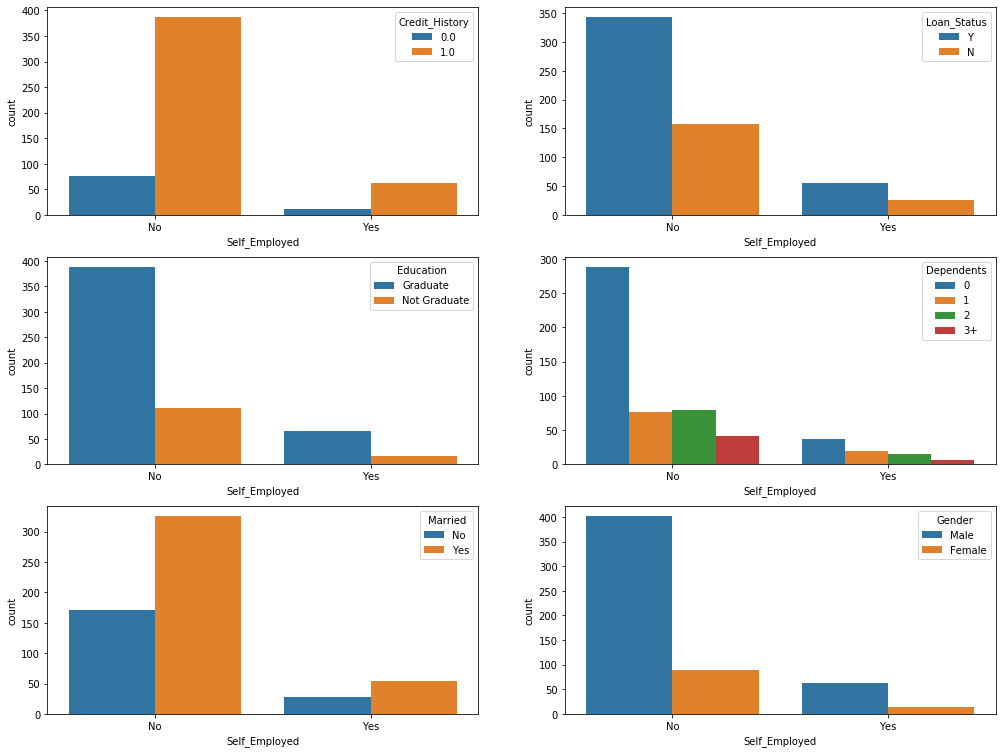

In [201]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(17,13))
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Credit_History", ax=axs[0,0])
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Loan_Status", ax=axs[0,1])
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Education", ax=axs[1,0])
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Dependents", ax=axs[1,1])
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Married", ax=axs[2,0])
sns.countplot(x="Self_Employed",data=loan_train_exploration, hue="Gender", ax=axs[2,1])
#appology for size :)

Nothing extra here, I won't be able to predict whether customer is self_employed or not based on categorical data, income will have to suffice for this purpose.

*Self_employed column suggestions*
- Nan values need to be filled based on income and proportion.
- I can try both - Nominal and Ordinal encoding, because loan companies consider beign Self_employed as bad, and vice versa
- It would be great try ML prediction separately (for Self employed and not).
- Meaning self_employed is less than employed.

<div class="alert alert-block alert-warning"><b>ApplicantIncome & CoapplicantIncome columns</b></div>

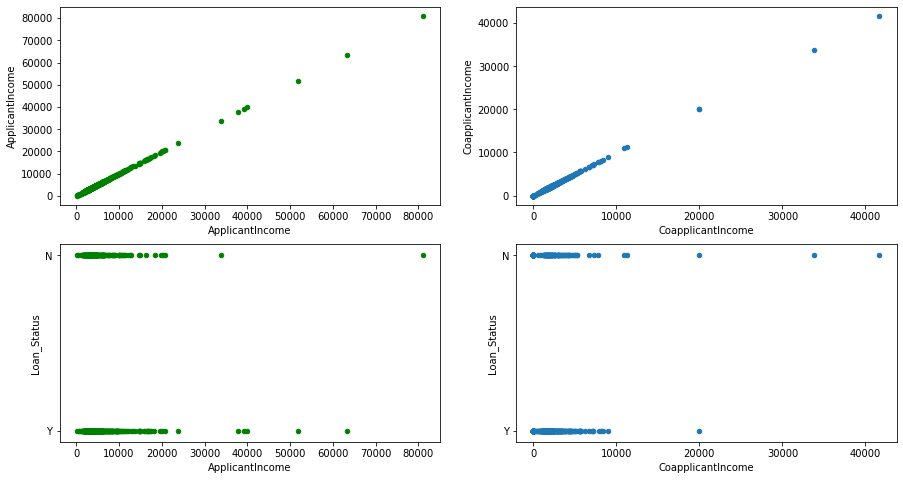

In [232]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15,8))
loan_train_exploration.plot.scatter('ApplicantIncome', 'ApplicantIncome', ax=axs[0,0], color="green")
loan_train_exploration.plot.scatter('CoapplicantIncome', 'CoapplicantIncome', ax=axs[0,1])
loan_train_exploration.plot.scatter('ApplicantIncome', 'Loan_Status', ax=axs[1,0], color="green")
loan_train_exploration.plot.scatter('CoapplicantIncome', 'Loan_Status', ax=axs[1,1])

At first glance, we can see that distribution for ApplicantIncome and CoapplicantIncome income is very similar, but we can also see that a big income is not so important, for example applicant with highest income was denied. Also it's quite obvious that CoapplicantIncome feature has lower weight then ApplicantIncome. Luckily these columns does not have Nan values...i suppose they are mandatory.

*ApplicantIncome & CoapplicantIncome columns suggestions*
- Maybe creating new column with total income.
- Create a simple mechanism which will delete outliers (on train only), I wanna try to identify a companies mistakes, meaning appliers with high income, good credit history but with negative Loan_Status and vice versa.
- Possibility to use StandardScaler, Normalizer and none is a matter of course.

<div class="alert alert-block alert-warning"><b>LoanAmount & Loan_Amount_Term columns</b></div>

These two columns are simple. I will drop rows if both of them will have Nan values, cause the prediction would not make sense without knowing how much they have to pay and for how long.

In [316]:
loan_train_exploration[(loan_train_exploration["LoanAmount"].isna()) \
                       & (loan_train_exploration["Loan_Amount_Term"].isna())]
#filter rows where is LoanAmount and Loa_Amount_Term missing

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Has2Income,income_total


But this case probably won't happen. We will have at least one feature, either LoanAmount or Loan_Amount_Term. Now for Nan values: the simple way is just calculate average or median for LoanAmount and Loan_Amount_Term and use one to fill the other.

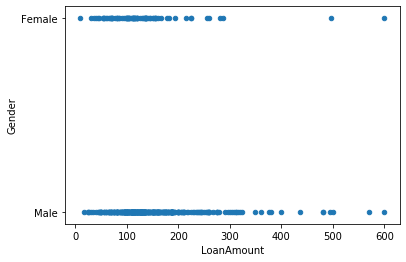

In [260]:
loan_train_nan = loan_train_exploration.dropna()
loan_train_nan.plot.scatter('LoanAmount', "Gender")

Here is just an example, probably Male apply for bigger Loans and so on. It would be good idea to calculate average LoanAmount for more "stereotypes".

*LoanAmount & Loan_Amount_Term columns suggestions*
- Calculate missing LoanAmoutn or Loan_Amount_Term with simple average or using a couple of them for different groups of people.
- Create new column Month payment, LoanAmoutn and Loan_Amount_Term are not a very good fit for Income columns.

<div class="alert alert-block alert-warning"><b>Credit_History column</b></div>

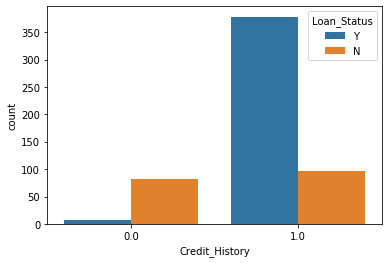

In [313]:
sns.countplot(x="Credit_History",data=loan_train_exploration, hue="Loan_Status")

In [314]:
credit_column = loan_train_exploration[["Credit_History","Loan_Status"]].groupby(["Loan_Status","Credit_History"]).size()
credit_column.Y[1]/(credit_column.N[1]+credit_column.Y[1]),credit_column.Y[0]/(credit_column.Y[0]+credit_column.N[0]);

<code style="background:yellow;color:black">Acceptace rate for Credit History 1 and 0 is 79% and 7,8%</code>

Well this column is probably the most important. I have clear Recall-Precision trade off and i will definitely need to try more Nan variants. 

*Credit_History column suggestions*
- Nan v.1 -> if missing just use 0.
- Nan v.2 -> fill Nan based on proportions .
- Nan v.3 -> try ML algorithm to predict these Nan values.
- Nan v.4 -> delete rows for training and fill Nan for test.
- Nan v.5 -> Something else if the results won't be good enough.

<div class="alert alert-block alert-warning"><b>Property_Area column</b></div>

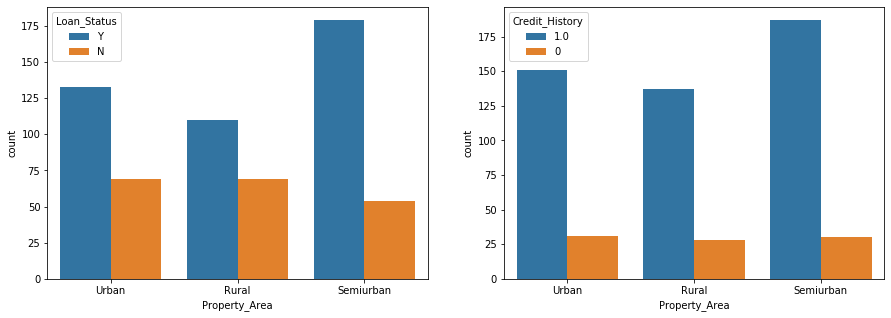

In [286]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
sns.countplot(x="Property_Area",data=loan_train_exploration, hue="Loan_Status", ax=axs[0])
sns.countplot(x="Property_Area",data=loan_train_exploration, hue="Credit_History", ax=axs[1],hue_order = [1.0, 0] )

I can see that Property_Area can affect Loan_Status quite a lot, or and that is interesting, Credit_History. It's quite visible on charts.

In [315]:
property_col = loan_train_exploration[["Property_Area","Loan_Status"]].groupby(["Loan_Status","Property_Area"]).size()
property_col.Y[2]/(property_col.Y[2]+property_col.N[2]), property_col.Y[0]/(property_col.Y[0]+property_col.N[0]), \
property_col.Y[1]/(property_col.N[1]+property_col.Y[1]);

<code style="background:yellow;color:black">Acceptace rate for Urban, Rural, Semiurban is 66%, 61%, 77%</code>

*Property_Area column suggestions*
- no Nan 
- Ordinal variables where Rural is worst, Urban is better and Semiurban is best 

And that's it! Data visualization is done, hopefully I've gathered enough information to create a well performing model.

<p style="background:white">
<code style="background:white;color:white">
</code>
</p>

## Custom transformers and data preparation

___

> 1) Split, Pipelines, Modeling, Tuning
>> 2) easy Nan values, more complicated ones
>>> 3) Encoding for nominal and ordinal variables
>>>> 4) Adding new columns, dropping ones
>>>>> 5) Credit_history solution - multiple versions

A simple scheme, in Jupyter everything will be written gradually but I will be doing everything in different order: 1-1, 1-2,1-3,1-4,1-5.

<div class="alert alert-block alert-warning"><b>Basic imports: </b> all import necessary for transformers, pipelines, model selection and hyperparameters tuning.</div>

In [1193]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import precision_score, recall_score, \
confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#from random import randint
import random
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as encoders
from sklearn.ensemble import VotingClassifier

### Custom Transformers

The main purpose of writing custom transformer is not for data modifying, but hyperparameters tuning, ability to change content of table in many ways and find out what is the best data composition! And beign able to answer question like...does my model predict better or worse with Gender column? 

<div class="alert alert-block alert-success"><b>Step 1: Nan Custom Transformer</b></div><a id='DataChanger_nan'></a>

In [2004]:
class DataChanger_nan(BaseEstimator, TransformerMixin):
    """Replacing nan values for loan prediction data set"""
    
    def __init__(self, credit_history_option=None):
        
        self.credit_history_option = credit_history_option
      
    def fit(self, data, y=None):
        """mandatory method for transformer"""        
        return self
    
    
    """____________________________________| METHOD FOR GENDER NAN VALUES |_____________________________________"""
    
    def gender(self,data):
        """Changing Nan in Gender column"""
        if "Gender" in data.columns:
            import random
            
            male_number = data["Gender"][(data["Gender"] == "Male")].count()
            female_number = data["Gender"][(data["Gender"] == "Female")].count()
            male_weight = male_number / (female_number+male_number)
            female_weight = female_number / (male_number+female_number)  
            
            index_gender = list(data.loc[pd.isna(data["Gender"]), :].index)
            values_gender = random.choices(population=["Female","Male"],weights=[male_weight,female_weight],
                                            k=len(index_gender))
            #first three rows i am calculating indexes of nana values, and than i am generating femaile
            #and male values based on train distribution
    
            gender_generator = pd.Series(list(values_gender), list(index_gender))
            data["Gender"].fillna(gender_generator, inplace = True)
            data["Gender"] = data["Gender"].astype("category") #better data type
            #last two rows i am creating pd.series from our two list and then i am 
            #filling nana values with this pd.series
            
   
    """_________________________________| METHOD FOR INDEPENDENTS NAN VALUES |__________________________________"""
    
    def dependents(self, data):
        """replacing nan values for Dependents based on their mean (probably 1 a 0 in every time but still)"""
        if "Dependents" in data.columns:
            data.loc[(data["Dependents"] == "3+"),"Dependents"] = 3
            married_dep_val = int(data[["Dependents"]][(data["Married"] == "Yes")].dropna\
                                  (axis=0).astype(int).mean())
            not_married_dep_val = int(data[["Dependents"]][(data["Married"] == "No")].dropna\
                                      (axis=0).astype(int).mean())
            #this might look scary, but it just filter our dependets column in table based on 
            #yes/no in married columndropping nan values and calculating the mean

            #i am changing nan values for both tables - filling nana values
            data.loc[(data["Dependents"].isna())& (data["Married"] == "Yes"),"Dependents"] = married_dep_val
            data.loc[(data["Dependents"].isna())& ((data["Married"] == "No") | (data["Married"].isna()))\
                                                   ,"Dependents"] = not_married_dep_val
            #i need to also assign dependents if married is nan - it is Married x Dependents tradeoff
            #assumpiton is easy married has 1 independents, not married 0
            data["Dependents"] = data["Dependents"].astype(int) #better data type
            
      
    """___________________________________| METHOD FOR MARRIED NAN VALUES |____________________________________"""
    
    def married(self, data):
        """replacing nan value for married based on number of independents and coapplicant income"""
        if "Married" in data.columns:
            data.loc[(data["Married"].isna())& (data["CoapplicantIncome"] == 0)\
                     & (data["Dependents"] == 0) ,"Married"] = "No"
            data.loc[(data["Married"].isna())& (data["Dependents"] > 0) ,"Married"] = "Yes" 
            data.loc[(data["Married"].isna())& (data["CoapplicantIncome"] > 0) ,"Married"] = "Yes"
            #ASSUMPITON is easy, coapplicant income > 0 = MARRIED, independents > 0 = MARRIED
            # coapplicant income and independets == 0 ==> NOT MARRIED
            data["Married"] = data["Married"].astype("category") #better data type
    
    
    """________________________________| METHOD FOR SELF_EMPLOYED NAN VALUES |_________________________________"""
    
    def employed(self, data):
        """replacing nan values for self_employed based on proportion and income"""
        if "Self_Employed" in data.columns:
            #calculating our weight to be self_employed - same approach as in gender
            self_ey = data["Self_Employed"][(data["Self_Employed"] == "Yes")].count()
            self_not_ey = data["Self_Employed"][(data["Self_Employed"] == "No")].count()
            self_employed_rate = self_ey / (self_ey+self_not_ey)
            self_note_eployed_rate = self_not_ey / (self_ey+self_not_ey)
            
            #calculating precise numbers of self_employed and ...
            number_of_nan = data["Self_Employed"].isna().sum()
            number_self_employed = int(number_of_nan*self_employed_rate)
            number_not_self_employed = number_of_nan-number_self_employed
                          
            #assign values - filtering top X values from nan (based on income) and bottom X
            indexes_self_employ = data[data["Self_Employed"]\
            .isna()].nlargest(number_self_employed,["ApplicantIncome"]).index.tolist() 
            indexes_not_self_employ = data[data["Self_Employed"]\
            .isna()].nsmallest(number_not_self_employed,["ApplicantIncome"]).index.tolist()   
            
            #now i filter based on my indexes and filling values
            data.loc[(data["Self_Employed"].\
            index.isin(indexes_self_employ)),"Self_Employed"] = "Yes" 
            data.loc[(data["Self_Employed"].\
            index.isin(indexes_not_self_employ)),"Self_Employed"] = "No" 
            
        #I keep it simple, I have bigger chance that self_employed will have higher income then not a s_y
        #therefore I will just assing values based on that and based on proportions
      
    """__________________________________| METHOD FOR LOAN_AMOUNT_AND_TERM|___________________________________"""
    
    def loan_amount_and_term(self, data):
        """replacing nan values for loan amount and loan amount term"""
        if "LoanAmount" and "Loan_Amount_Term" in data.columns:
                data["LoanAmount"] = data["LoanAmount"]*1000
                loan_nan = data.loc[(data["LoanAmount"].isna())& (data["Loan_Amount_Term"].isna())]
                #my condition for having nan values for LoanAmount and also for Loan_Amount_Term 
                #if these two things happens i have to drop entire row

                if len(loan_nan):#dropping rows - how all is important i want delete my rows only
                    #in case when i have two nan values in same row!
                    data.dropna(subset=["LoanAmount","Loan_Amount_Term"], how="all", inplace = True)

                elif not len(loan_nan):
                    #firstly we will calculate loan average
                    loan_average = data[["LoanAmount","Loan_Amount_Term"]].dropna() #need to drop all nan values
                    loan_average = int((loan_average["LoanAmount"] / loan_average["Loan_Amount_Term"]).mean())


                    #and now we fill na values with it
                    data.loc[(data["LoanAmount"].isna()),"LoanAmount"] = data["Loan_Amount_Term"]* loan_average
                    data.loc[(data["Loan_Amount_Term"].isna()),"Loan_Amount_Term"] = \
                    data["LoanAmount"] / loan_average

                    data["Loan_Amount_Term"] = data["Loan_Amount_Term"].astype(int)
        
        
    """__________________________________| CREDIT_HISTORY ADDED AFTER STEP3|___________________________________"""
    
    def credit_history(self, data):
        """dropping all rows where is Vredit_History missing"""
        
        if self.credit_history_option == 1: #just filling with 0
            data["Credit_History"].fillna(0, inplace=True)
            
        if self.credit_history_option == 2:
            credit_yes = data["Credit_History"][(data["Credit_History"] == 1)].count()
            credit_no = data["Credit_History"][(data["Credit_History"] == 0)].count()
            credit_rate_yes = credit_yes / (credit_yes+credit_no)
            credit_rate_no = credit_no / (credit_yes+credit_no)
            #calculation proportions for credit history

            data["family_for_calc"] = (data["ApplicantIncome"]+data["CoapplicantIncome"]) \
            - (data["Dependents"].astype(int)*500)
            #creating our own column family balance - cost per person is set to 500
            #it could be great for parameter tuning probably?

            #calculating number of yes and no values
            len_coef = data["Credit_History"].isna().sum()
            credit_yes = int(credit_rate_yes *len_coef)
            credit_no = len_coef - credit_yes

            #i am vreating my data for credit history
            no_series = data.loc[(data["Credit_History"].isna())\
                                  ,["Credit_History","family_for_calc"]].sort_values\
            (by="family_for_calc")[:credit_no]["Credit_History"].fillna(0)
            #no values

            yes_series = data.loc[(data["Credit_History"].isna())\
                                   ,["Credit_History","family_for_calc"]].sort_values\
            (by="family_for_calc")[credit_no:]["Credit_History"].fillna(1)
            #yes values

            #no i fillna my values
            data["Credit_History"].fillna(no_series, inplace = True)
            data["Credit_History"].fillna(yes_series, inplace = True)
            data.drop("family_for_calc", axis=1, inplace=True)
            
    """_________________________________________________| SUMMARY|______________________________________________"""
    
    def transform(self, data):
        self.gender(data)
        self.dependents(data)
        self.married(data)
        self.employed(data)
        self.loan_amount_and_term(data)
        self.credit_history(data)
        
        return data
        

<div class="alert alert-block alert-info"><b>Note 3:</b> Apology for docstring above, but i cannot help myself. </div>

My first Customer is finished, it's just a lot of scary hard coding. Now I can look if it performs well.

In [2005]:
DataChanger_nan().fit_transform(pd.read_csv("train.csv")).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Loan_ID            614 non-null    object  
 1   Gender             614 non-null    category
 2   Married            614 non-null    category
 3   Dependents         614 non-null    int32   
 4   Education          614 non-null    object  
 5   Self_Employed      614 non-null    object  
 6   ApplicantIncome    614 non-null    int64   
 7   CoapplicantIncome  614 non-null    float64 
 8   LoanAmount         614 non-null    float64 
 9   Loan_Amount_Term   614 non-null    int32   
 10  Credit_History     564 non-null    float64 
 11  Property_Area      614 non-null    object  
 12  Loan_Status        614 non-null    object  
dtypes: category(2), float64(3), int32(2), int64(1), object(5)
memory usage: 49.5+ KB


From this point of view everything looks fine. Every column has 614 non-nul values, meaning data has no Nan values, except  Credit History column. We will see, if adjustments will have positive or negative effect on model performance. Next stop: Credit_History!

<div class="alert alert-block alert-success"><b>Step 2: Dropping and adding columns</b></div><a id='ColumnsChanger'></a>

I wanna have possibility to drop columns and add some new ones. It has to be done after Nan values replacer and before encoding procedures. The cherry on the cake will be use of class parameters as hyperparameters in pipeline.

In [1597]:
class ColumnsChanger(BaseEstimator, TransformerMixin):
    """Drop and adds some columns"""
    
    def __init__(self, 
                cost_per_month = False, #for adding cost per month column
                family_balance = False, #for adding family balance column
                cost_per_person = 500, #cost per person - used in family balance
                family_loan_cost = False, #adding extra substraction for family balance
                columns_to_drop = None): #for dropping all columns
        
        self.columns_to_drop = columns_to_drop
        self.cost_per_month = cost_per_month
        self.family_balance = family_balance
        self.cost_per_person = cost_per_person
        self.family_loan_cost = family_loan_cost
                 
    def fit(self, data, y=None):
        """mandatory method for transformer"""        
        return self
    
    def add_cost_per_month(self, data):
        """adds new column to our dataset - cost per month"""
        if self.cost_per_month:
            data["Cost_per_month"] = round((data["LoanAmount"] / data["Loan_Amount_Term"]),1)
            #i guess rounding is not so important issue here, so i leave it as that..
            
            """Skipped - better to delete columns seperately!"""
            #if self.cost_per_month[1]: #don't wanna endup with 0 columns total :)
                #data.drop(["LoanAmount","Loan_Amount_Term"], axis = 1, inplace = True)
                
    def add_family_balance(self, data):
        """ads new column to our dataset - family balance"""
        if self.family_balance:
            data["family_balance"] = (data["ApplicantIncome"]+data["CoapplicantIncome"]) \
            - (data["Dependents"].astype(int)* self.cost_per_person \
            + (self.family_loan_cost and (round((data["LoanAmount"] / data["Loan_Amount_Term"]),1))))
            #if family_loan_cost false i substract 0, if True i substract average cost_per month!
    
    def rename_columns(self, data):
        """Renaming function - important for encoding part"""
        new_names = {"Gender": "Gender_OHE", 
                     "Married": "Married_OHE",
                     "Self_Employed" : "Self_Employed_OHE",
                     "Education": "Education_OHE",
                     "Property_Area": "Property_Area_OHE",
                     
                     "ApplicantIncome" : "ApplicantIncome_NUM",
                     "CoapplicantIncome" : "CoapplicantIncome_NUM",
                     "LoanAmount" : "LoanAmount_NUM",
                     "Loan_Amount_Term" : "Loan_Amount_Term_NUM",
                     "Cost_per_month" : "Cost_per_month_NUM",
                     "family_balance" : "family_balance_NUM",
                    
                    "Loan_Status": "Loan_Status_OTHER",
                    "Credit_History" : "Credit_History_OTHER",
                    "Dependents" : "Dependents_OTHER"}
                     
        return data.rename(columns=new_names, inplace=True)
    
    def transform(self, data):
        
        self.add_cost_per_month(data)
        self.add_family_balance(data)
        self.columns_to_drop and data.drop(self.columns_to_drop, 1, inplace=True) #and = False or END, or True or END
        #deleting of columns must be the last part - we don't wanna delete columns which could be required for building
        #another ones..
        self.rename_columns(data)
            
        return data

And that is it! Dropping every colum I want is good, and about adding, we could add something like..family size and so on. But family_balance and cost_per_month looks good enough to me.

In [1669]:
columns_data = DataChanger_nan().fit_transform(pd.read_csv("train.csv"))

In [1670]:
columns_to_delete = ["Loan_ID","Loan_Status","Credit_History"]

columns_changed = ColumnsChanger(cost_per_month = True,
               family_balance = True,
               family_loan_cost = True,
               cost_per_person = 1000,
               columns_to_drop=columns_to_delete).fit_transform(columns_data)

columns_changed.head()

,Gender_OHE,Married_OHE,Dependents_OTHER,Education_OHE,Self_Employed_OHE,ApplicantIncome_NUM,CoapplicantIncome_NUM,LoanAmount_NUM,Loan_Amount_Term_NUM,Property_Area_OHE,Cost_per_month_NUM,family_balance_NUM
0,Male,No,0,Graduate,No,5849,0.0,172800.0,360,Urban,480.0,5369.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128000.0,360,Rural,355.6,4735.4
2,Male,Yes,0,Graduate,Yes,3000,0.0,66000.0,360,Urban,183.3,2816.7
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120000.0,360,Urban,333.3,4607.7
4,Male,No,0,Graduate,No,6000,0.0,141000.0,360,Urban,391.7,5608.3


With using a little bit of math I can easily check whether my function works fine. For example second row - Depenndetns = 1, meaning costs = 1000, total income 6091. cost_per_month 356 => family balance is equal to 4735 (6091 - 1000 - 356).

<div class="alert alert-block alert-success"><b>Step 3: encoding and decoding</b></div><a id='encoding_decoding'></a>

The biggest problem is wheter to use nominal or ordinal encoding. Because the main purpose is to learn, i want try more combinations. 

In [2142]:
class NumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer_name = None,column_transfer = []):
        
        self.transformer_name = transformer_name
        self.column_transfer = column_transfer
        self.mappings = []

    def fit(self, data, y=None):
        """mandatory method for transformer"""        
        return self
    
    
    def transform(self, data):
        #lists of columns
        numeric_columns = [col for col in data.columns if "_NUM" in col] #columns for numeric pipelines
        #all of my columns are supposed to be nominal, if I don't say otherwise 
        ohe_columns = [col for col in data.columns if "_OHE" in col if col not in self.column_transfer]
        ode_columns = self.column_transfer #optional ordinal columns - based on my transformer parameter

        #mapping - this must be hardcoded 
        Property_Area_OHE = {'col': 'Property_Area_OHE', 'mapping': {"Semiurban" : 3, "Urban": 2, "Rural": 1}}
        Education_OHE = {'col': 'Education_OHE', 'mapping': {"Graduate" : 1, "Not Graduate" : 0}}
        Self_Employed_OHE = {"col" : "Self_Employed_OHE", "mapping" : {"No" : 0, "Yes" : 1}}
        
        #better this easy way - may mapping has to be flexible
        if "Property_Area_OHE" in self.column_transfer:
            self.mappings.append(Property_Area_OHE)
        if "Education_OHE" in self.column_transfer:
            self.mappings.append(Education_OHE)
        if "Self_Employed_OHE" in self.column_transfer:
            self.mappings.append(Self_Employed_OHE)

        #individual pipelines
        num_pipeline = Pipeline([("optional num transformer", self.transformer_name())]) 
        nominal_pipeline = Pipeline([("One_Hot_Encoder", OneHotEncoder())])
        ordinal_pipeline = Pipeline\
        ([("Ordinal_Encoder", encoders.OrdinalEncoder(mapping = self.mappings))])

        
        #final pipeline
        colum_transformer = ColumnTransformer([("numeric", num_pipeline, numeric_columns),
                                              ("nominal", nominal_pipeline, ohe_columns),
                                                ("ordinal",ordinal_pipeline, ode_columns)
                                              ],remainder='passthrough')
                 
        return colum_transformer.fit_transform(data)

This part is a little heavier. I have columns I do not care like dependents and credit history (at least for now), 5 numeric columns, they are really easy but I have option to use both StandardScaler and Normalizer, and all ofmy categorical columns are nominal as default, but I can change some of them - Property_Area, Education and Self_Employed to ordinal if i want to. 

In [1914]:
trying_encoder = NumTransformer(StandardScaler, column_transfer =["Property_Area_OHE"])

In [1915]:
trying_encoder.fit_transform(columns_changed)[0]

array([ 7.29908229e-02, -5.54487330e-01,  3.06715367e-01,  3.03623801e-01,
       -5.92148660e-04, -6.69627504e-02,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  2.00000000e+00,  0.00000000e+00])

<div class="alert alert-block alert-success"><b>Step 4: Credit_History</b></div><a id='credit_history'></a>

Possible approaches:

1. Nan fill with 0
2. Proportions and simple logic
3.  ~~ML model - skipped, model will probably preditct same 1 ~~
4.  ~~Deleting rows on train - skipped ~~

Option 1 and 2 is just simplier if I only modify Nan class from step1 and give an option - no replacing, option 1 or 2 and that's it.

In [2003]:
    """__________________________________| CREDIT_HISTORY ADDED AFTER STEP3|___________________________________"""
    
    def credit_history(self, data):
        """dropping all rows where is Vredit_History missing"""
        
        if self.credit_history_option == 1: #just filling with 0
            data["Credit_History"].fillna(0, inplace=True)
            
        if self.credit_history_option == 2:
            credit_yes = data["Credit_History"][(data["Credit_History"] == 1)].count()
            credit_no = data["Credit_History"][(data["Credit_History"] == 0)].count()
            credit_rate_yes = credit_yes / (credit_yes+credit_no)
            credit_rate_no = credit_no / (credit_yes+credit_no)
            #calculation proportions for credit history

            data["family_for_calc"] = (data["ApplicantIncome"]+data["CoapplicantIncome"]) \
            - (data["Dependents"].astype(int)*500)
            #creating our own column family balance 
            
            #calculating number of yes and no values
            len_coef = data["Credit_History"].isna().sum()
            credit_yes = int(credit_rate_yes *len_coef)
            credit_no = len_coef - credit_yes

            #i am vreating my data for credit history
            no_series = data.loc[(data["Credit_History"].isna())\
                                  ,["Credit_History","family_for_calc"]].sort_values\
            (by="family_for_calc")[:credit_no]["Credit_History"].fillna(0)
            #no values

            yes_series = data.loc[(data["Credit_History"].isna())\
                                   ,["Credit_History","family_for_calc"]].sort_values\
            (by="family_for_calc")[credit_no:]["Credit_History"].fillna(1)
            #yes values

            #no i fillna my values
            data["Credit_History"].fillna(no_series, inplace = True)
            data["Credit_History"].fillna(yes_series, inplace = True)
            data.drop("family_for_calc", axis=1, inplace=True)

Here is my basic function i added to Nan custom transformer, with ML model I will have 3 possibilities of how to replace my Nan values and see the differences.

In [2006]:
DataChanger_nan(credit_history_option=2).fit_transform(pd.read_csv("train.csv")).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Loan_ID            614 non-null    object  
 1   Gender             614 non-null    category
 2   Married            614 non-null    category
 3   Dependents         614 non-null    int32   
 4   Education          614 non-null    object  
 5   Self_Employed      614 non-null    object  
 6   ApplicantIncome    614 non-null    int64   
 7   CoapplicantIncome  614 non-null    float64 
 8   LoanAmount         614 non-null    float64 
 9   Loan_Amount_Term   614 non-null    int32   
 10  Credit_History     614 non-null    float64 
 11  Property_Area      614 non-null    object  
 12  Loan_Status        614 non-null    object  
dtypes: category(2), float64(3), int32(2), int64(1), object(5)
memory usage: 49.5+ KB


Something like that :), first option just fillna with 0 (it's most common approach), if you don't have credit history you expect 0 and second is just using proportions and total income - costs to guess better (maybe?). But that is all, no more custom transformers!

## All together - split, pipelines, model selection and hyperparameter tuning

<div class="alert alert-block alert-danger"><b>Step 1 completition: after Nan custom transformer</b></div>

Well I have only one customer and nothing else, nothing to complete right now. Ofcourse I could use ML model and so on, but now it would be just a waste of time. Structure of model is simple.

1. Data loading
2. Labels splitting
3. Train and Test splitting
4. Train - fit_transform 
5. Test - transform

[Link to Data changer class - replacer for Nan values](#DataChanger_nan)

In [1936]:
pipeline_datachanger = Pipeline([("changing data", DataChanger_nan())]) #nan replacer
split_data = pd.read_csv("train.csv") #loading data
X, y = split_data.iloc[:,:-1], split_data.iloc[:,-1] #labels off
n = 20

for _ in range(n):
    #splitting to train, test with n splits
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=random.randint(15,30)/100) #i am also using randomized split for now from 15-30%
    
    X_train = pipeline_datachanger.fit_transform(X_train)
    X_test = pipeline_datachanger.transform(X_test)

Here is nothing special..yet. It's just custom version of splitting data into train and test, you can notice that I am fit_transformimg data to my X_train, but for test I use only transform method. In same cases we won't notice any difference in final result, but better do it "right".

<div class="alert alert-block alert-danger"><b>Step 2 completition: after Columns dropper and adder </b></div>

[Link to ColumnChanger class - drops and create new columns](#encoding_decoding)

In [882]:
columns_to_delete = ["Loan_ID","Married","Gender","Education"]

pipeline_datachanger = Pipeline([("changing data", DataChanger_nan())]) #nan replacer
pipeline_columnschanger = Pipeline([("adding and deleting columns", ColumnsChanger(columns_to_drop=columns_to_delete,
                                                                                  cost_per_month = True, 
                                                                                family_balance = True))])
#just packing two pipelines above together
full_pipeline = Pipeline(steps=[("basic change", pipeline_datachanger),
                              ("column_transformer", pipeline_columnschanger)])


split_data = pd.read_csv("train.csv") #loading data
X, y = split_data.iloc[:,:-1], split_data.iloc[:,-1] #labels off
n = 20

for _ in range(n):
    #splitting to train, test with n splits
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=random.randint(15,30)/100) #i am also using randomized split for now from 15-30%
    
    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)

In [883]:
X_train.head()

,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Cost_per_month,family_balance
334,1,Yes,9833,1833.0,182000.0,180,1.0,Urban,1011.1,11166.0
212,1,Yes,7787,0.0,240000.0,360,1.0,Urban,666.7,7287.0
237,0,Yes,3463,0.0,122000.0,360,NaN,Urban,338.9,3463.0
246,2,No,9703,0.0,112000.0,360,1.0,Urban,311.1,8703.0
172,3,No,3522,0.0,81000.0,180,1.0,Rural,450.0,2022.0


Everything works fine i can continue with encoding.

<div class="alert alert-block alert-danger"><b>Step 3 completition: after encoding and decoding</b></div>

[Link to NumTransformer class - encoding](#ColumnsChanger)

In [1941]:
columns_to_delete = ["Loan_ID","Credit_History"]

pipeline_datachanger = Pipeline([("changing data", DataChanger_nan())]) #nan replacer
pipeline_columnschanger = Pipeline([("adding and deleting columns", ColumnsChanger(columns_to_drop=columns_to_delete,
                                                                                  cost_per_month = False, 
                                                                                family_balance = False))])

pipeline_encoder = Pipeline([("encoding", NumTransformer(StandardScaler, column_transfer =["Property_Area_OHE"]))])


#just packing two pipelines above together
full_pipeline = Pipeline(steps=[("basic change", pipeline_datachanger),
                              ("column_transformer", pipeline_columnschanger),
                               ("encoding",pipeline_encoder)])


split_data = pd.read_csv("train.csv") #loading data
X, y = split_data.iloc[:,:-1], split_data.iloc[:,-1] #labels off
n = 20

for _ in range(n):
    #splitting to train, test with n splits
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=random.randint(15,30)/100) #i am also using randomized split for now from 15-30%
    
    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)

<div class="alert alert-block alert-info"><b>Note4: </b> If my model won't be performing good, this is a first stop for checking what is going wrong.</div>

***Simple playground***

In [1964]:
columns_to_delete = ["Loan_ID","Gender","Married","Education","Self_Employed","ApplicantIncome",\
                    "CoapplicantIncome","LoanAmount","Loan_Amount_Term","Loan_Status"]

In [1965]:
pipeline_encoder = Pipeline([("encoding", NumTransformer(StandardScaler, column_transfer =["Property_Area_OHE"]))])
pipeline_columnschanger = Pipeline([("adding and deleting columns", ColumnsChanger(columns_to_drop=columns_to_delete,
                                                                                  cost_per_month = False, 
                                                                                family_balance = False))])
pipeline_datachanger = Pipeline([("changing data", DataChanger_nan())])

In [1966]:
full_pipeline2 = Pipeline(steps=[("basic change", pipeline_datachanger),
                              ("column_transformer", pipeline_columnschanger),
                               ("encoding",pipeline_encoder)])

In [1976]:
trying = full_pipeline2.fit_transform(pd.read_csv("train.csv"))

In [1960]:
filter_arr = trying == 3

In [1961]:
trying[filter_arr].shape

(284,)

I am just looking if I have enough of threes and number is luckily correct :). I have 51x 3+ in train.csv and 233 customers living in Semiurban. Only thing which can go wrong with my last transformer is ordinal encoding, no need to check other data.

## Final Model

### Model selection

Finally it's time to finish whole project. Previous 3 steps, were just building block for this part, i just wanted to make sure that everything is working before i will pack all together.

<div class="alert alert-block alert-danger"><b>Step 4 completition: Creating ML model</b></div>

[Link to Credit_History update](#credit_history)

<div class="alert alert-block alert-warning"><b>Basic lists for score metrics</b>

In [2501]:
n = 20 #coefficient for my iterations..
precision, recall, acurracy = [], [], [] #lists for recieving testing results
final, pre_max, re_max, acc_max = [], [], [], [] #and lists for final table with top results
pre_min, re_min, acc_min = [], [], [] #and my min. values
pre_avg, re_avg, acc_avg = [], [], [] #and average values
classifier_list = [(type(classifier).__name__) for classifier in classifiers]
#i am just listing all names of my classifiers - so they are only names and not callables

<div class="alert alert-block alert-warning"><b>Classifiers</b>

In [2502]:
classifiers = [
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    ]

<div class="alert alert-block alert-warning"><b>Pipelines</b>

I need to also choose my options for filling Credit_History column.

In [2503]:
columns_to_delete = ["Loan_ID","Gender"]

pipeline_datachanger = Pipeline([("changing data", DataChanger_nan(credit_history_option=2))]) #nan replacer
pipeline_columnschanger = Pipeline([("adding and deleting columns", ColumnsChanger(columns_to_drop=columns_to_delete,
                                                                                  cost_per_month = True, 
                                                                                family_balance = True))])

pipeline_encoder = Pipeline([("encoding", NumTransformer(Normalizer, column_transfer =\
                                                         ["Property_Area_OHE"]))])


full_pipeline = Pipeline(steps=[("basic change", pipeline_datachanger),
                              ("column_transformer", pipeline_columnschanger),
                               ("encoding",pipeline_encoder)])

<div class="alert alert-block alert-warning"><b>Testing</b>

In [2504]:
X_y = pd.read_csv("train.csv")
X, y = X_y.iloc[:,:-1], X_y.iloc[:,-1:]

for _ in range(n):
    #splitting to train, test with n splits
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=random.randint(15,30)/100) #i am also using randomized split for now from 15-30%
    
    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)
    
    for classifier in classifiers: #i will iterate through all of my classifiers
        classifier.fit(X_train, y_train) #training my data
        y_pred = classifier.predict(X_test) #making a prediction
        recall.append(recall_score(y_test, y_pred, pos_label='Y'))
        precision.append(precision_score(y_test, y_pred, pos_label='Y'))
        acurracy.append(accuracy_score(y_test,y_pred)) 

<div class="alert alert-block alert-warning"><b>Evaluating</b>

In [2505]:
#getting data for my evaluation table        
for s in range(len(classifier_list)):
    pre_max.append(max(precision[s::len(classifier_list)]))
    re_max.append(max(recall[s::len(classifier_list)]))
    acc_max.append(max(acurracy[s::len(classifier_list)]))
    final.append(classifier_list[s])

    pre_min.append(min(precision[s::len(classifier_list)]))
    re_min.append(min(recall[s::len(classifier_list)]))
    acc_min.append(min(acurracy[s::len(classifier_list)]))

    pre_avg.append(np.mean(precision[s::len(classifier_list)]))
    re_avg.append(np.mean(recall[s::len(classifier_list)]))
    acc_avg.append(np.mean(acurracy[s::len(classifier_list)]))

#final results of my models   
final_result = pd.DataFrame(None)
final_result = pd.DataFrame(data = {"classifier" : final,
                                    "Recall_min" : re_min,
                                    "Recall_avg" : re_avg,
                                    "Recall_max" : re_max,
                                    "Precision_min" : pre_min,
                                    "Precision_avg" : pre_avg,
                                    "Precision_max" : pre_max,
                                    "Accuracy_min" : acc_min,
                                    "Accuracy_avg" : acc_avg,
                                    "Accuracy_max" : acc_max,                                                                                    
    })

final result

,classifier,Recall_min,Recall_avg,Recall_max,Precision_min,Precision_avg,Precision_max,Accuracy_min,Accuracy_avg,Accuracy_max
0,SVC,1.000000,1.000000,1.000000,0.650000,0.697265,0.774775,0.650000,0.697265,0.774775
1,DecisionTreeClassifier,0.710843,0.787412,0.920635,0.713115,0.780408,0.850000,0.651163,0.696706,0.753521
2,RandomForestClassifier,0.837607,0.904379,0.959016,0.748092,0.805084,0.851485,0.697674,0.780512,0.828571
3,AdaBoostClassifier,0.870229,0.914631,0.980769,0.753247,0.797658,0.864078,0.739437,0.778603,0.852713
4,GradientBoostingClassifier,0.846154,0.914838,0.960396,0.736842,0.793665,0.852632,0.709302,0.775125,0.830986
5,ExtraTreesClassifier,0.783133,0.877090,0.936170,0.730769,0.792835,0.846154,0.709677,0.754089,0.821705
6,BaggingClassifier,0.753846,0.844661,0.932692,0.740458,0.804252,0.873950,0.686869,0.748120,0.809524
7,LogisticRegression,0.661538,0.952802,0.982301,0.739130,0.794096,0.844037,0.676768,0.794834,0.852713
8,LinearDiscriminantAnalysis,0.846154,0.956714,0.980769,0.739130,0.792193,0.844037,0.744186,0.795066,0.852713


Model has something about 80% average accuracy at best. I will use LogisticRegression model for hyperparameter tunning and Randomforrest classifier.

<p style="background:black">
<code style="background:black;color:white">TOP RESULTS LDA: Recall = 0.956714, Acurracy = 0.795066 Precision = 0.792193)
</code>
</p>

### Hyperparameters and Model tuning

<div class="alert alert-block alert-warning"><b>Basic settings:</b> our pipe and split</div>

In [2506]:
from sklearn.model_selection import GridSearchCV

Firstly some mandatory splitting, only a simple verison.

In [2523]:
def split_for_tuning():
    X_y = pd.read_csv("train.csv")
    X_y = X_y.drop("Loan_ID", axis=1)
    X, y = X_y.iloc[:,:-1], X_y.iloc[:,-1:]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.35) 
    
    return X_train, X_test, y_train, y_test

Next stop, is setting up my pipelines for GridSearch.

In [2511]:
full_pipeline_log = Pipeline(steps=[("basic_change", DataChanger_nan()),
                              ("column_transformer", ColumnsChanger()),
                               ("encoding",NumTransformer()),
                               ("classifier",LogisticRegression())])

<div class="alert alert-block alert-info"><b>Note5:</b> It is my first time i am doing GridSearch with custom transformer so it is a little clumsy :), one important note - better to use default parameters in custom transformers, because GridSearch except callable - probably a default form of transformer. If you don't have default parameters you can still add them in your param_grid.</div>

<div class="alert alert-block alert-warning"><b>LF Hyperparameters</b></div>

It's very straightforward, I am going to try some combinations for all of four transformers and hopefully be able to improve prediction a little bit. I could try more combinations but it would take more time, even for dataset small like this one, therefore I use only these i consider more important.

**For LogisticRegression**

In [2524]:
#if I will have somewhere only one options I probably filter the second out - so i could decrease a computation time

param_grid_log = {
    "basic_change__credit_history_option" : [2,1],
    
    #columns changer param
    "column_transformer__cost_per_month" : [True, False],
    "column_transformer__family_balance" : [True, False],
    "column_transformer__cost_per_person" : [0, 500, 3000],
    "column_transformer__family_loan_cost" : [False, True],
    #i could you combinations but for this purpose this will be enough
    "column_transformer__columns_to_drop" : ["Gender", "Married"],                                         
    
    #encoding param
    "encoding__transformer_name" : [Normalizer, StandardScaler], 
    "encoding__column_transfer" : ["Property_Area_OHE","Education_OHE","Self_Employed_OHE"],                            
    #classifier param
    "classifier__C" : np.logspace(-4,4,20),
    "classifier__solver" : ['liblinear'],
    "classifier__penalty" : ['l1', 'l2']
    
}

In [2646]:
log = GridSearchCV(full_pipeline_log, param_grid_log, n_jobs= 1)
X_train, X_test, y_train, y_test = split_for_tuning()

In [2649]:
log_model = log.fit(X_train, y_train)

In [2653]:
log_model.best_params_ , log_model.best_score_

({'basic_change__credit_history_option': 2,
  'classifier__C': 0.08858667904100823,
  'classifier__penalty': 'l2',
  'classifier__solver': 'liblinear',
  'column_transformer__columns_to_drop': 'Married',
  'column_transformer__cost_per_month': True,
  'column_transformer__cost_per_person': 0,
  'column_transformer__family_balance': True,
  'column_transformer__family_loan_cost': False,
  'encoding__column_transfer': 'Education_OHE',
  'encoding__transformer_name': sklearn.preprocessing._data.Normalizer},
 0.8045253164556962)

We have are optional hyperparameters for Logisticregression, but there is no significant difference, maybe a minor one.

**For RandomForrest**

In [2580]:
full_pipeline_forrest = Pipeline(steps=[("basic_change", DataChanger_nan()),
                              ("column_transformer", ColumnsChanger()),
                               ("encoding",NumTransformer()),
                               ("classifier",RandomForestClassifier())])

In [2581]:
param_grid_forrest = {
    #columns changer param
    "column_transformer__cost_per_month" : [True],
    "column_transformer__family_balance" : [True, False],
    "column_transformer__cost_per_person" : [0],
    "column_transformer__family_loan_cost" : [False, True],
    #i could you combinations but for this purpose this will be enough
    "column_transformer__columns_to_drop" : ["Gender"],                                         
    
    #encoding param
    "encoding__transformer_name" : [Normalizer], #this one is simple
    "encoding__column_transfer" : ["Property_Area_OHE","Education_OHE","Self_Employed_OHE"],
    
    #classifier param
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy'],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__min_samples_split': [2, 4, 6],}

In [2650]:
forrest = GridSearchCV(full_pipeline_forrest, param_grid_forrest, n_jobs= 1)
X_train, X_test, y_train, y_test = split_for_tuning()

In [ ]:
forrest_model = forrest.fit(X_train, y_train)

In [2657]:
forrest.best_params_, forrest.best_score_

({'classifier__criterion': 'gini',
  'classifier__max_depth': 4,
  'classifier__max_features': 'auto',
  'classifier__min_samples_leaf': 1,
  'classifier__min_samples_split': 2,
  'classifier__n_estimators': 100,
  'column_transformer__columns_to_drop': 'Gender',
  'column_transformer__cost_per_month': True,
  'column_transformer__cost_per_person': 0,
  'column_transformer__family_balance': True,
  'column_transformer__family_loan_cost': False,
  'encoding__column_transfer': 'Property_Area_OHE',
  'encoding__transformer_name': sklearn.preprocessing._data.Normalizer},
 nan)

Our top score is Nan but i guess there won't be any big difference, I will use this setting anyway.

<div class="alert alert-block alert-danger"><b>Combining more models together</b></div>

I would like to try combine some of the best models.

In [2664]:
estimator = []
estimator.append(('LOG', LogisticRegression(C =0.8858667904100823, 
                                            penalty = "l2", 
                                            solver = "liblinear")))


estimator.append(('RFC', RandomForestClassifier(criterion = "gini",
                                                max_depth = 4,
                                                max_features = "auto",
                                                min_samples_leaf =  1,
                                                min_samples_split = 2,
                                                n_estimators = 100)))  #randomforrest a top parametry
estimator.append(('ADA', AdaBoostClassifier()))


In [2665]:
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')

In [2670]:
columns_to_delete = ["Loan_ID","Gender"] #married 50/50

pipeline_datachanger = Pipeline([("changing data", DataChanger_nan(credit_history_option=2))]) #nan replacer
pipeline_columnschanger = Pipeline([("adding and deleting columns", ColumnsChanger(columns_to_drop=columns_to_delete,
                                                                                  cost_per_month = True, 
                                                                                family_balance = True,
                                                                                  cost_per_person = 0,
                                                                                  family_loan_cost = False))])

pipeline_encoder = Pipeline([("encoding", NumTransformer(Normalizer, column_transfer =\
                                                         ["Property_Area_OHE", "Education_OHE"]))])


full_pipeline = Pipeline(steps=[("basic change", pipeline_datachanger),
                              ("column_transformer", pipeline_columnschanger),
                               ("encoding",pipeline_encoder)])

In [2671]:
X_y = pd.read_csv("train.csv")
X, y = X_y.iloc[:,:-1], X_y.iloc[:,-1:]
recall, precision, acurracy = [], [], []

for _ in range(n):
    #splitting to train, test with n splits
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=random.randint(15,30)/100) #i am also using randomized split for now from 15-30%
    
    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)
    
    vot_soft.fit(X_train, y_train) #training my data
    y_pred = vot_soft.predict(X_test) #making a prediction
    recall.append(recall_score(y_test, y_pred, pos_label='Y'))
    precision.append(precision_score(y_test, y_pred, pos_label='Y'))
    acurracy.append(accuracy_score(y_test,y_pred)) 

In [2673]:
np.mean(recall), np.mean(acurracy), np.mean(precision);

<p style="background:black">
<code style="background:black;color:white">Recall = 0.956796138507087, Acurracy = 0.8091159618855348 Precision = 0.8086178386973651)
</code>
</p>

In [2680]:
confusion_matrix(y_test, y_pred)

array([[ 19,  32],
       [  4, 130]], dtype=int64)

We can see that we pushed our model a little bit. This is probably best result I achieved in this project.

<div class="alert alert-block alert-danger"><b>Deleting outliers from train</b></div>

Here i wanna try a small experiment. I will delete outliers from train and see if I can predict better. My outliers are unlucky rich and lucky poor :), the ones which were accepted or rejected by mistake (in my opinion). I will predict my values 

In [2674]:
def deleting_outliers(data):
    """optional functio for dropping an outliers based on quantil - default is 0.9"""
    quaintile_rate_upper = outlier_quantil_rate #calculating our quantil rate and limits
    quaintile_rate_lower = 1-quaintile_rate_upper
    lower_limit = data["ApplicantIncome"].quantile(quaintile_rate_lower)
    upper_limit = data["ApplicantIncome"].quantile(quaintile_rate_upper)

    #our condition for top and bottom quantil - considering credit_histor and loan status
    unlucky_rich = data[(data["ApplicantIncome"] > upper_limit)& (data["Credit_History"]== 1.0)& \
                        (data["Loan_Status"]== "N")]

    lucky_poor = data[(data["ApplicantIncome"] < lower_limit)&(data["Credit_History"]== 0.0)& \
                        (data["Loan_Status"]== "Y")]

    data.drop(lucky_poor.index.union(unlucky_rich.index), inplace=True)
    return data

Now the process is very similar, just a small change in my split.

In [2734]:
n = 20 #coefficient for my iterations..
precision, recall, acurracy = [], [], [] #lists for recieving testing results
outlier_quantil_rate = 0.9

"""_________________________________________________SPLIT AND TESTING______________________________________________"""
X_y = pd.read_csv("train.csv") 

for _ in range(n):
    X_train ,X_test = train_test_split(X_y, test_size=random.randint(15,30)/100)
    X_train = deleting_outliers(X_train) #OUTLIER DELETER!

    X_train, y_train = X_train.iloc[:,:-1], X_train.iloc[:,-1:]
    X_test, y_test = X_test.iloc[:,:-1], X_test.iloc[:,-1:]

    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)
    
    vot_soft.fit(X_train, y_train) #training my data
    y_pred = vot_soft.predict(X_test) #making a prediction
    recall.append(recall_score(y_test, y_pred, pos_label='Y'))
    precision.append(precision_score(y_test, y_pred, pos_label='Y'))
    acurracy.append(accuracy_score(y_test,y_pred)) 

In [2740]:
np.mean(recall), np.mean(precision), np.mean(acurracy);

<p style="background:black">
<code style="background:black;color:white">Recall = 0.9551932878195849, Acurracy = 0.7879577644503296 Precision = 0.7927027027027027)
</code>
</p>

My outlier deletion didn't add any improvement.

<div class="alert alert-block alert-danger"><b>Deleting Nan Credit_History from train + outliers</b>

In [2791]:
n = 50 #coefficient for my iterations..
precision, recall, acurracy = [], [], [] #lists for recieving testing results
outlier_quantil_rate = 0.8
y_test_m, y_pred_m = [], []

"""_________________________________________________SPLIT AND TESTING______________________________________________"""
X_y = pd.read_csv("train.csv") 

for _ in range(n):
    X_train ,X_test = train_test_split(X_y,test_size=random.randint(15,30)/100) 
    X_train = deleting_outliers(X_train) #Deleting outliers
    X_train = X_train.dropna(subset=["Credit_History"])#Deleting Credit_History Nan
    
    X_train, y_train = X_train.iloc[:,:-1], X_train.iloc[:,-1:]
    X_test, y_test = X_test.iloc[:,:-1], X_test.iloc[:,-1:]

    X_train = full_pipeline.fit_transform(X_train)
    X_test = full_pipeline.transform(X_test)
    
    vot_soft.fit(X_train, y_train) #training my data
    y_pred = vot_soft.predict(X_test) #making a prediction
    recall.append(recall_score(y_test, y_pred, pos_label='Y'))
    precision.append(precision_score(y_test, y_pred, pos_label='Y'))
    acurracy.append(accuracy_score(y_test,y_pred)) 
    y_test_m.append(y_test)
    y_pred_m.append(y_pred)

So this is probably best model I have. Maximum accuracy is something about 86% and 80 on average.

In [2792]:
pd.DataFrame(data = {"Recall" : [max(recall),np.mean(recall), np.min(recall)],
                                    "Precision" : [max(precision),np.mean(precision), np.min(precision)],
                                    "Accuracy" : [max(acurracy),np.mean(acurracy), np.min(acurracy)]
                                                                                                                        
    },index=["Max","Mean","Min"])

,Recall,Precision,Accuracy
Max,1.000000,0.858209,0.867470
Mean,0.961707,0.795371,0.802271
Min,0.935897,0.722772,0.717949


This is my final model. There is always something to improve. But i will end it like this. Let's look at Confusion Matrix.

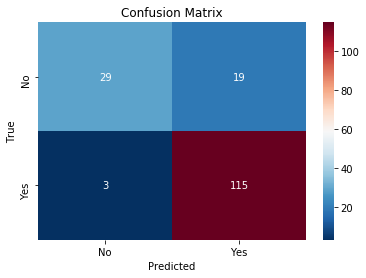

In [2814]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test_m[27], y_pred_m[27]), annot=True, ax = ax, fmt='g', cmap='RdBu_r'); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);

<div class="alert alert-block alert-success"><b>Interpretation</b></div

1. Model predict 134 YES values but in fact there were only 118 YES values. In other words, my model is too benevolent, and it gives loans to customer who should not get one.
2. Model predict 32 NO values but in fact there were 48 NO values. This statement corresponds with first one.

It's not surprising when our model has a high recall and lower precision! It depends what we want, for 2008 this would be probably great model but for now, it would be better to decrease recall a little bit and therefore increase precision. And most importantly, find out how to make the model more selective, then it would have better overall results.

<div class="alert alert-block alert-info"><b>Note 6:</b> I was only using train.csv, test.csv is without labels and can be used only on analyticsvidhya.com</div>

***The end***